# This notebook will contain the model training process, evaluation, and hyperparameter tuning:

- Model selection (e.g., logistic regression, random forest, etc.)

- Splitting data into train/test sets

- Model training, evaluation, and cross-validation

- Hyperparameter tuning

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import h2o
from h2o.automl import H2OAutoML

### Input 02-notebook file

In [25]:
path = '../data/cleaned/heart_2022_cleaned_02.csv'

In [26]:
# read data
df = pd.read_csv(path ,sep=',',encoding='utf-8')
df.sample(5)

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,SleepHours,HadHeartAttack,SmokerStatus,ECigaretteUsage,HeightInMeters,WeightInKilograms,...,BMI^2,BMI SleepHours,BMI MentalHealthDays,BMI PhysicalHealthDays,SleepHours^2,SleepHours MentalHealthDays,SleepHours PhysicalHealthDays,MentalHealthDays^2,MentalHealthDays PhysicalHealthDays,PhysicalHealthDays^2
232312,1,4,-0.491530,-0.515488,0.656772,0,2,0,0.746709,0.051512,...,704.3716,212.32,0.00,0.00,64.0,0.0,0.0,0.0,0.0,0.0
320722,0,4,-0.491530,1.289245,-0.687687,0,3,0,-0.024913,-0.103725,...,752.9536,164.64,411.60,0.00,36.0,90.0,0.0,225.0,0.0,0.0
41219,0,2,1.256021,-0.515488,2.673460,0,3,1,-0.700082,-0.725653,...,663.0625,283.25,0.00,386.25,121.0,0.0,165.0,0.0,0.0,225.0
196162,0,4,-0.491530,-0.515488,0.656772,0,2,1,-0.507176,-1.125744,...,482.6809,175.76,0.00,0.00,64.0,0.0,0.0,0.0,0.0,0.0
127338,0,2,-0.258523,-0.274857,-2.032146,0,3,0,-0.024913,-0.103725,...,752.9536,109.76,54.88,54.88,16.0,8.0,8.0,4.0,4.0,4.0


In [27]:
output_path = '../data/cleaned/dtype.csv'
df.dtypes.to_csv(output_path)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442067 entries, 0 to 442066
Columns: 149 entries, Sex to PhysicalHealthDays^2
dtypes: bool(102), float64(35), int64(12)
memory usage: 201.5 MB


### Splitting data into train/test sets

In [31]:
# Start H2O cluster
h2o.init()
# Convert data into H2O frame (required by H2O)
h2o_df = h2o.H2OFrame(df)
h2o_df['HadHeartAttack'] = h2o_df['HadHeartAttack'].asfactor()

# Specify the target column
target = 'HadHeartAttack'

# Define the feature columns
features = [col for col in df.columns if col != target]

# Split the dataset into training and testing sets
train, test = h2o_df.split_frame(ratios=[.8], seed=42)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment Homebrew (build 11.0.27+0); OpenJDK 64-Bit Server VM Homebrew (build 11.0.27+0, mixed mode)
  Starting server from /Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmpwjdfgee3
  JVM stdout: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmpwjdfgee3/h2o_chiushihchan_started_from_python.out
  JVM stderr: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmpwjdfgee3/h2o_chiushihchan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Taipei
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 6 days
H2O_cluster_name:,H2O_from_python_chiushihchan_cpotle
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### Select and Train the Best Mode

In [32]:
# Train the AutoML model
aml = H2OAutoML(max_models=20, max_runtime_secs = 200, seed=42)
aml.train(x=features, y=target, training_frame=train)

# Get the leaderboard of models
lb = aml.leaderboard
print(lb)

# Get the best model and evaluate it on the test set
best_model = aml.leader
predictions = best_model.predict(test)

# Evaluate model performance on the test set
performance = best_model.model_performance(test)
print(performance)


AutoML progress: |
21:46:34.710: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                             auc    logloss     aucpr    mean_per_class_error      rmse        mse
GBM_2_AutoML_1_20250503_214632  0.881682   0.149648  0.400896                0.279388  0.201164  0.040467
GBM_3_AutoML_1_20250503_214632  0.881333   0.149663  0.397341                0.258841  0.201229  0.0404931
GBM_4_AutoML_1_20250503_214632  0.878992   0.151808  0.381993                0.264628  0.202926  0.0411791
GLM_1_AutoML_1_20250503_214632  0.877333   0.15162   0.398206                0.265436  0.202415  0.0409717
GBM_1_AutoML_1_20250503_214632  0.876069   0.151646  0.387775                0.27263   0.202237  0.0408999
DRF_1_AutoML_1_20250503_214632  0.868793   0.154097  0.381742                0.271326  0.203318  0.0413383
XRT_1_AutoML_1_20250503_214632  0.865469   0.159664  0.359058                0.282899  0.20734

In [49]:
# Get feature importance for the best model
feature_importance = best_model.varimp()

# Print the feature importance to check the columns and structure
print(feature_importance)


[('HadAngina_Yes', 8994.7509765625, 1.0, 0.5375728993353648), ('HadStroke_Yes', 1323.1639404296875, 0.1471040103141752, 0.07907912932845057), ('ChestScan_Yes', 493.3528137207031, 0.05484896858247947, 0.029485319066437827), ('DifficultyWalking_Yes', 434.0674133300781, 0.04825785777295243, 0.02594211651871971), ('Sex', 386.26678466796875, 0.042943577390242245, 0.023085303405505145), ('HadDiabetes_Yes', 319.22967529296875, 0.0354906629571826, 0.019078818585226885), ('RemovedTeeth_All', 202.1054229736328, 0.02246926274004207, 0.012078866717092499), ('GeneralHealth', 190.39813232421875, 0.021167693560426137, 0.01137917839952081), ('AgeCategory_Age 80 or older', 182.68482971191406, 0.020310159801859264, 0.010918191490650065), ('HeightInMeters PhysicalHealthDays', 165.38180541992188, 0.018386479609147046, 0.009884073152059742), ('HeightInMeters SleepHours', 155.56919860839844, 0.017295553708353124, 0.00929762095260991), ('SmokerStatus', 149.0281524658203, 0.016568346678428447, 0.0089066941611

In [51]:
# Convert feature importance to pandas DataFrame
feature_importance_df = pd.DataFrame(feature_importance)

feature_importance_df 


,0,1,2,3
0,HadAngina_Yes,8994.750977,1.000000,0.537573
1,HadStroke_Yes,1323.163940,0.147104,0.079079
2,ChestScan_Yes,493.352814,0.054849,0.029485
3,DifficultyWalking_Yes,434.067413,0.048258,0.025942
4,Sex,386.266785,0.042944,0.023085
...,...,...,...,...
143,BMI_Category_Underweight,0.858566,0.000095,0.000051
144,SleepHours_Category_Very Short Sleep,0.818694,0.000091,0.000049
145,LastCheckupTime_Within past 5 years (2 years b...,0.583880,0.000065,0.000035
146,"HadDiabetes_Yes, but only during pregnancy (fe...",0.133851,0.000015,0.000008


                                              variable  raw_importance  \
0                                        HadAngina_Yes     8994.750977   
1                                        HadStroke_Yes     1323.163940   
2                                        ChestScan_Yes      493.352814   
3                                DifficultyWalking_Yes      434.067413   
4                                                  Sex      386.266785   
..                                                 ...             ...   
143                           BMI_Category_Underweight        0.858566   
144               SleepHours_Category_Very Short Sleep        0.818694   
145  LastCheckupTime_Within past 5 years (2 years b...        0.583880   
146  HadDiabetes_Yes, but only during pregnancy (fe...        0.133851   
147                               State_Virgin Islands        0.000000   

     scaled_importance  relative_importance  
0             1.000000             0.537573  
1             0.147

/var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/ipykernel_22794/3663430142.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')


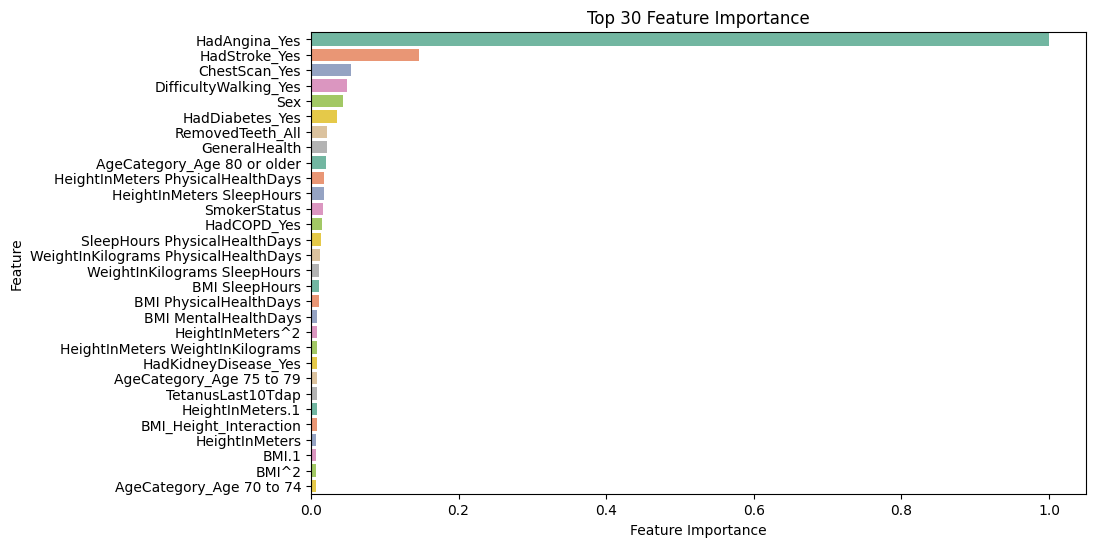

In [ ]:
# Convert feature importance into a pandas DataFrame
feature_importance_df = pd.DataFrame(feature_importance, columns=['variable', 'raw_importance', 'scaled_importance', 'relative_importance'])

# Sort the features by scaled importance in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by="scaled_importance", ascending=False)

# Print the sorted feature importance
print(feature_importance_df_sorted)

# Plot the top 30 most important features
top_30_features = feature_importance_df_sorted.head(30)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')

# Add labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 30 Feature Importance')

# Show the plot
plt.show()


                                              variable  raw_importance  \
147                               State_Virgin Islands        0.000000   
146  HadDiabetes_Yes, but only during pregnancy (fe...        0.133851   
145  LastCheckupTime_Within past 5 years (2 years b...        0.583880   
144               SleepHours_Category_Very Short Sleep        0.818694   
143                           BMI_Category_Underweight        0.858566   
..                                                 ...             ...   
4                                                  Sex      386.266785   
3                                DifficultyWalking_Yes      434.067413   
2                                        ChestScan_Yes      493.352814   
1                                        HadStroke_Yes     1323.163940   
0                                        HadAngina_Yes     8994.750977   

     scaled_importance  relative_importance  
147           0.000000             0.000000  
146           0.000

/var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/ipykernel_22794/2743676325.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')


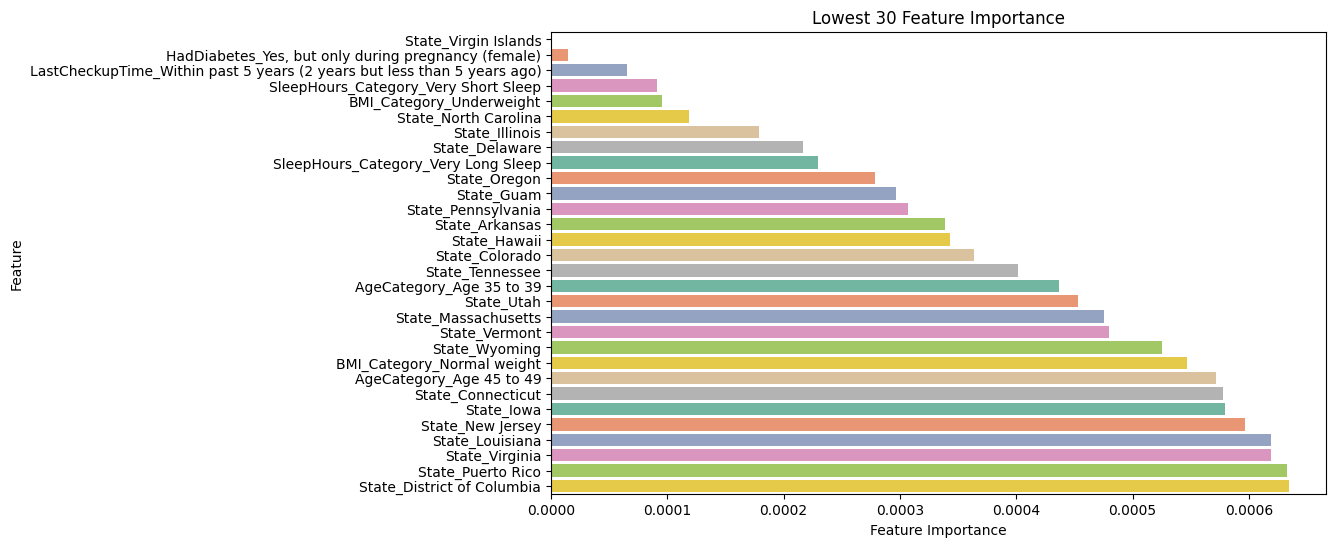

In [63]:
# Convert feature importance into a pandas DataFrame
feature_importance_df = pd.DataFrame(feature_importance, columns=['variable', 'raw_importance', 'scaled_importance', 'relative_importance'])

# Sort the features by scaled importance in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by="scaled_importance", ascending=True)

# Print the sorted feature importance
print(feature_importance_df_sorted)

# Plot the top 30 most important features
top_30_features = feature_importance_df_sorted.head(30)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')

# Add labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Lowest 30 Feature Importance')

# Show the plot
plt.show()